# Truy vấn ảnh tương đồng

## ResNet + FAISS

## Bộ hàm thư viện torch

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from PIL import Image

Canh cut:


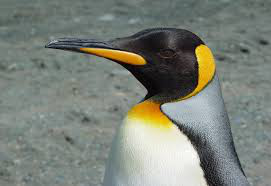

In [2]:
#Bố cục dataset thư mục root là chim, mỗi subfolder (thư mục con) là một ID Class, 1 ID Class có nhiều ảnh cùng ID
print('Canh cut:')
Image.open('/Users/jason/Downloads/chim/canh_cut/canh_cut_176.jpg')

In [3]:
# print('Dai bang:')
# Image.open('/Users/jason/Downloads/chim/dai_bang/dai_bang_1.jpg')

In [4]:
# print('Chim vang anh:\n')
# Image.open('/Users/jason/Downloads/chim/chim_vanganh/chim_vanganh_1.jpg')

In [5]:
# print('Thien nga:\n')
# Image.open('/Users/jason/Downloads/chim/thiennga/thiennga_2.jpg')

## Tạo database

Công đoạn này giúp thao tác tên file dễ dàng hơn. Kế thừa ImageFolder class. Cấu trúc file trong dataset (thư mục root chim gồm các thư mục con là ID Class)

In [6]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d"""
    
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # Đường dẫn file ảnh
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


## Tiền xử lí

In [7]:
transforms_ = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
dataset = ImageFolderWithPaths('/Users/jason/Downloads/chim', transforms_)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


## Downloading a pretrained model

In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet50(pretrained=True)
model

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jason/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Dùng output của last pooling layers để tạo the image descriptors

In [9]:
#giảm chiều vector đặc trưng descriptor
def pooling_output(x):
    global model
    for layer_name, layer in model._modules.items():
        x = layer(x)
        if layer_name == 'avgpool':
            break
    return x

## Extracting features đồng thời Classification với mạng học sâu ResNet

In [10]:
# iterate over data
image_paths = []
descriptors = []
model.to(DEVICE)
with torch.no_grad():
    model.eval()
    for inputs, labels, paths in dataloader:
        result = pooling_output(inputs.to(DEVICE))
        descriptors.append(result.cpu().view(1, -1).numpy())
        image_paths.append(paths)
        torch.cuda.empty_cache()

In [11]:
len(image_paths)

2220

In [12]:
image_paths[:5]

[('/Users/jason/Downloads/chim/canh_cut/canh_cut_0.jpg',),
 ('/Users/jason/Downloads/chim/canh_cut/canh_cut_1.jpg',),
 ('/Users/jason/Downloads/chim/canh_cut/canh_cut_10.jpg',),
 ('/Users/jason/Downloads/chim/canh_cut/canh_cut_100.jpg',),
 ('/Users/jason/Downloads/chim/canh_cut/canh_cut_101.jpg',)]

In [13]:
descriptors[0]

array([[0.05142464, 0.22510657, 0.86061484, ..., 0.5929263 , 0.24399604,
        0.5859443 ]], dtype=float32)

In [14]:
#Số chiều phải ứng với tham số đầu vào của hàm Độ đo đối sánh.
#Ví dụ (1, 2048) thì L2 ghi 2048, (1, 128) thì L2 ghi 128
descriptors[0].shape

(1, 2048)

## Cài đặt `faiss`

In [15]:
# !conda install -c pytorch faiss-cpu

## Đánh chỉ mục FAISS (tìm kiếm bằng bảng băm)

In [16]:
import numpy as np
import faiss

#Độ đo đối sánh Euclide distance
index = faiss.IndexFlatL2(2048)
#Độ đo đối sánh inner product
# index = faiss.IndexFlatIP(2048)

#Băm ảnh trong dataset vào bảng băm, phần tử bảng băm là ID Class, trong ID Class gồm nhiều ảnh
descriptors = np.vstack(descriptors)
index.add(descriptors)

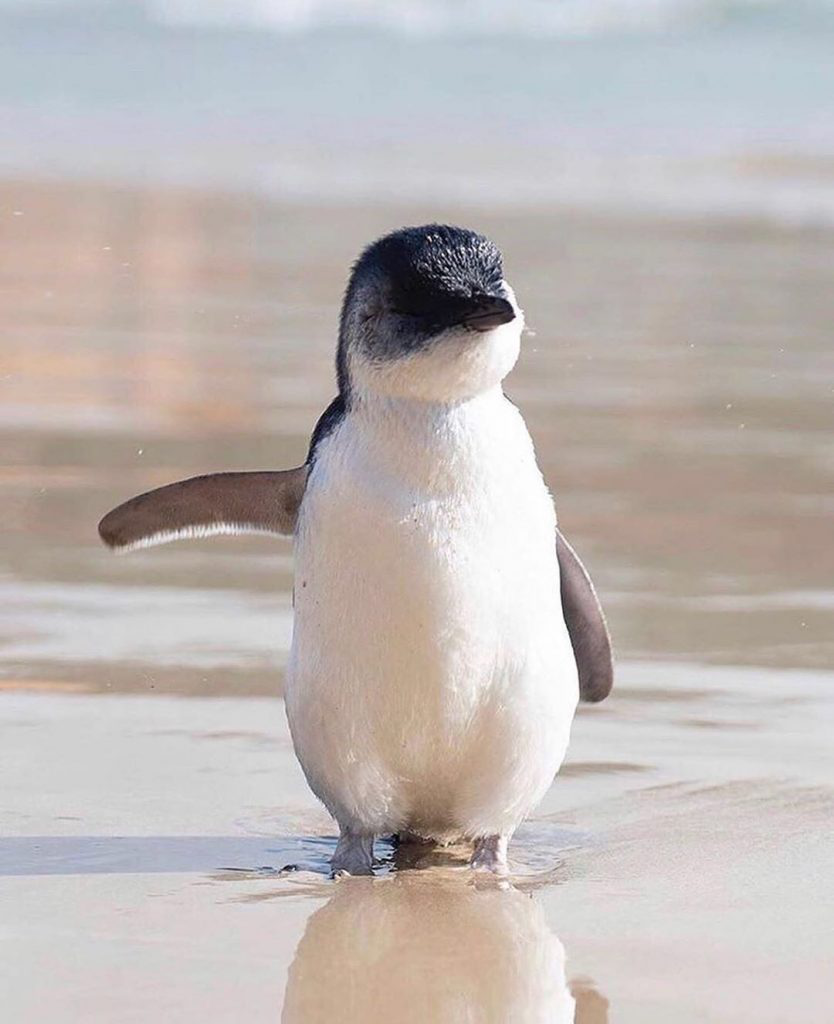

In [18]:
#Hiển thị ảnh query input
query_image = '/Users/jason/Downloads/19127517/canh_cut_query.jpg'
img = Image.open(query_image)
img

In [19]:
input_tensor = transforms_(img)
input_tensor = input_tensor.view(1, *input_tensor.shape)
with torch.no_grad():
    query_descriptors = pooling_output(input_tensor.to(DEVICE)).cpu().numpy()
    #Đối sánh ảnh query input và phần tử bảng băm ID Class bằng 1 độ đo đối sánh 
    distance, indices = index.search(query_descriptors.reshape(1, 2048), 9)


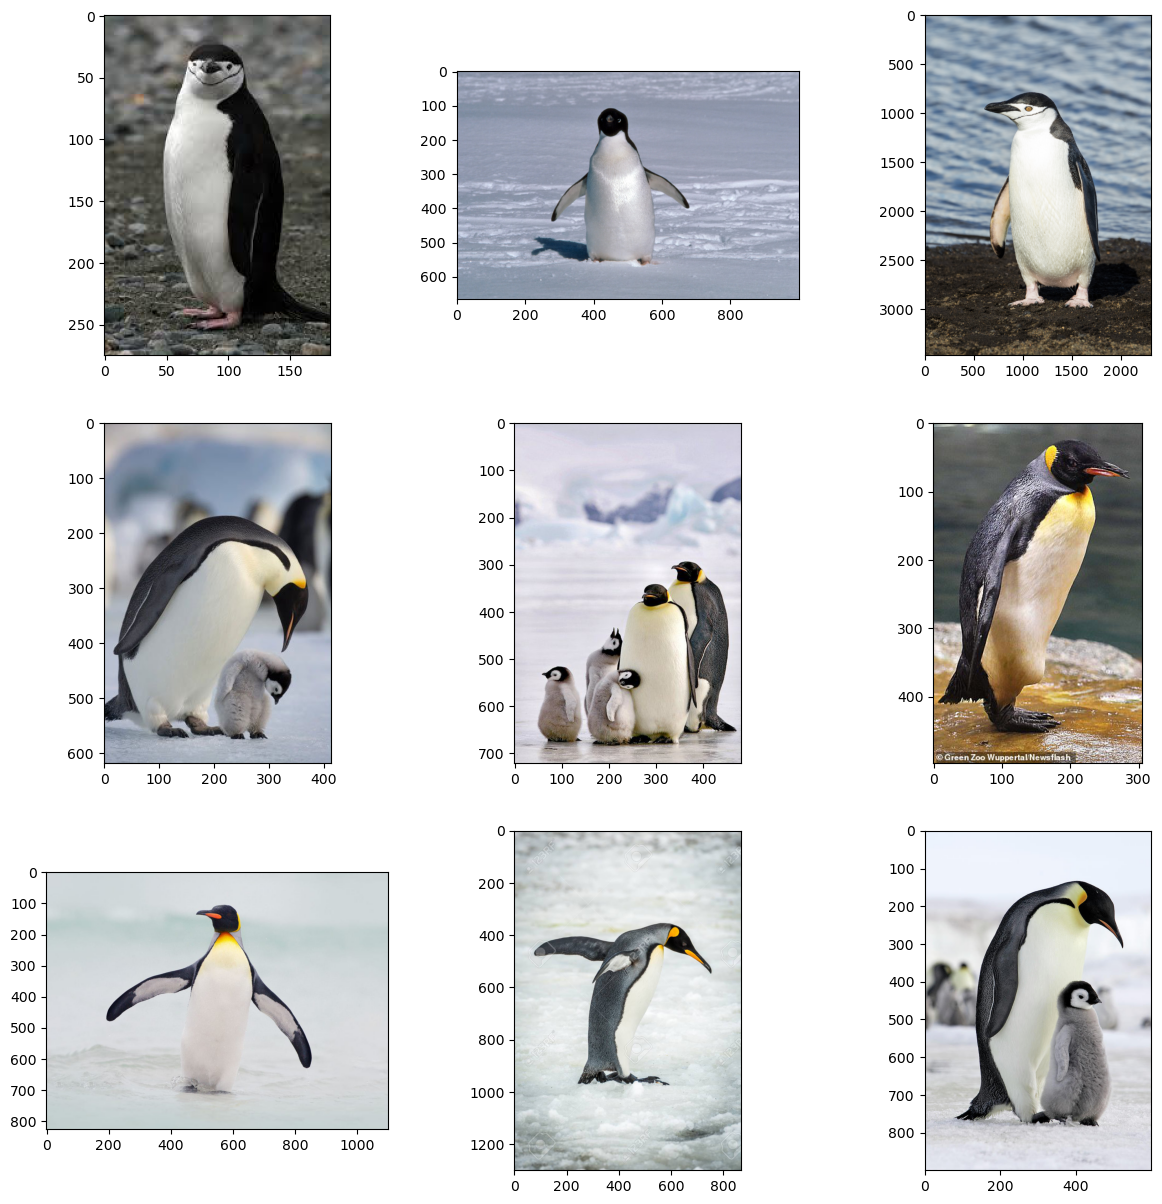

In [20]:
#Hiển thị output
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for file_index, ax_i in zip(indices[0], np.array(ax).flatten()):
    ax_i.imshow(plt.imread(image_paths[file_index][0]))

plt.show()

# SIFT + FAISS

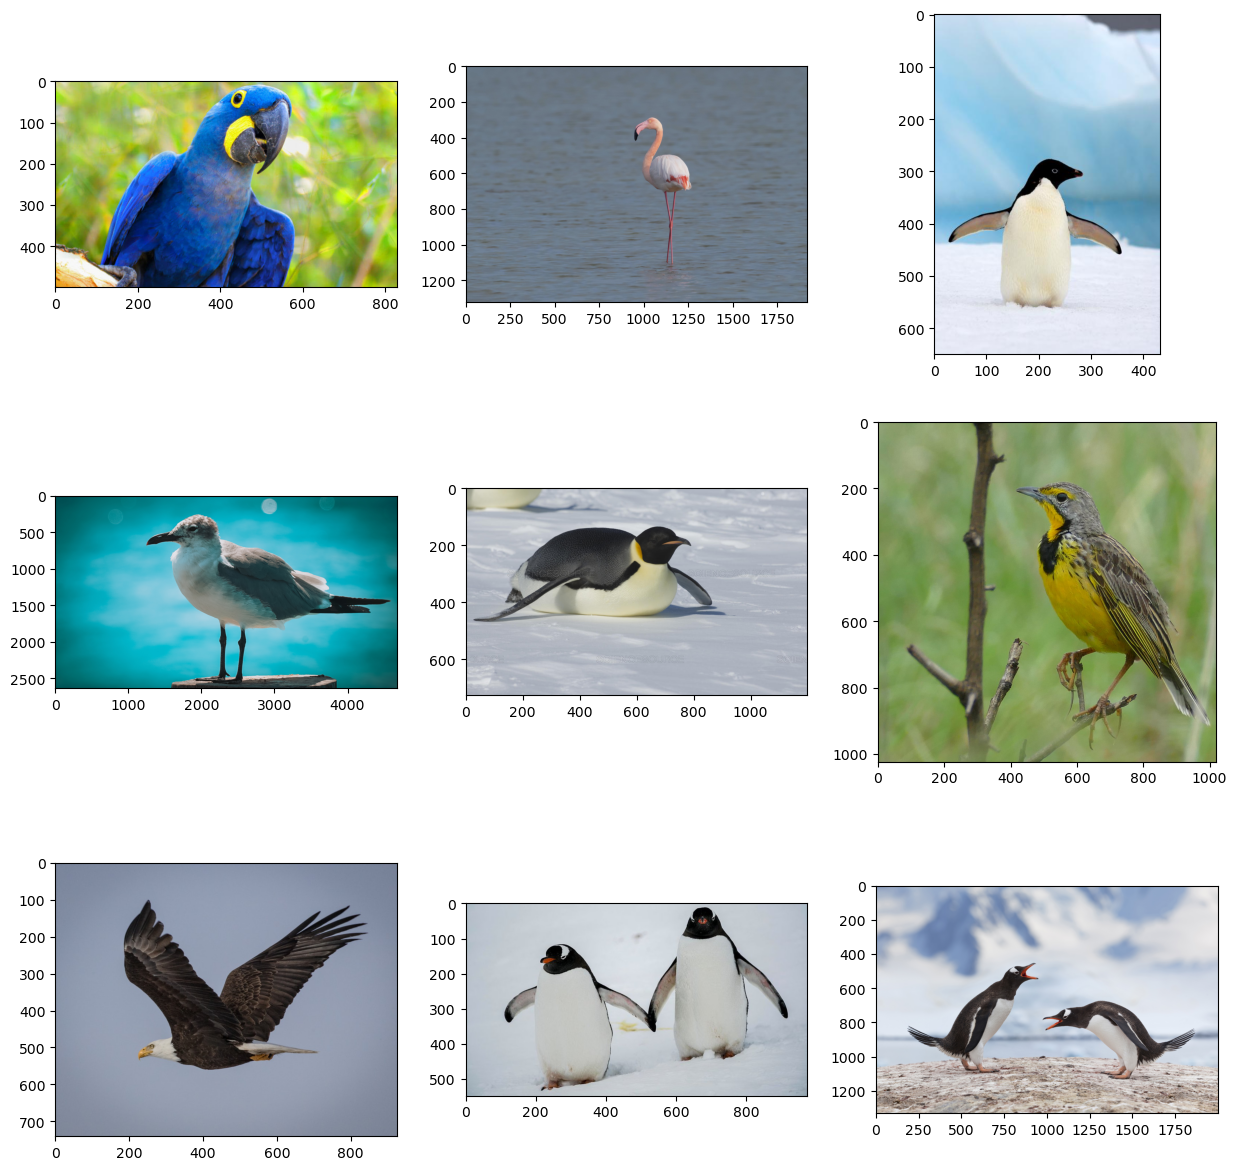

In [25]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from PIL import Image

#ImageFolderWithPaths kế thừa lớp ImageFolder giúp dễ dàng đọc path ảnh
class ImageFolderWithPaths(datasets.ImageFolder):
    """https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d"""
    
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

#Dataset: Thư mục root chim gồm các thư mục con là các ID Class (cánh cụt, đại bàng, vàng anh,..).
#Trong ID Class có nhiều ảnh cùng ID
transforms_ = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
dataset = ImageFolderWithPaths('/Users/jason/Downloads/chim', transforms_)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

# Rút trích Vector đặc trưng descriptor của ảnh query input
import cv2
import os
import logging
import uuid
import sys
NUM_FEATURES = 200
def get_sift():
  return cv2.SIFT_create(nfeatures=NUM_FEATURES, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)
sift = get_sift()
import os
NOR_X = 512
NOR_Y = 384
isAddPhash = False
import numpy as np
import logging
def calc_sift(sift, image_file):
  if not os.path.isfile(image_file):
    logging.error('Image:{} does not exist'.format(image_file))
    return -1, None
  try:
    image_o = cv2.imread(image_file)
  except:
    logging.error('Open Image:{} failed'.format(image_file))
    return -1, None
  if image_o is None:
    logging.error('Open Image:{} failed'.format(image_file))
    return -1, None
  image = cv2.resize(image_o, (NOR_X, NOR_Y))
  if image.ndim == 2:
    gray_image = image
  else:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  kp, des = sift.detectAndCompute(gray_image, None) #kp là các điểm đặc trưng ứng viên handcrafted, des là số chiều của kp
  if isAddPhash:
    des = adddPhash(gray_image, des)
  sift_feature = np.matrix(des)
  return 0, sift_feature
ret, sift_feature = calc_sift(sift, '/Users/jason/Downloads/19127517/canh_cut_query.jpg')
ids_count = 0
if ret == 0 and sift_feature.any():
    image_dict = {ids_count: ('/Users/jason/Downloads/19127517/canh_cut_query.jpg', sift_feature)}
# print(sift_feature[0].shape)

#Lấy vector đặc trưng những ảnh trong Dataset (descriptors)
image_paths = []
descriptors = []
with torch.no_grad():
    for inputs, labels, paths in dataloader:
        ret, sift_features = calc_sift(sift, paths[0])
        if ret == 0 and sift_features.any():
            image_dict = {ids_count: (paths, sift_features)}
            ids_count+=1
        descriptors.append(sift_features[0])
        image_paths.append(paths)
        torch.cuda.empty_cache()

import numpy as np
import faiss
#Độ đo đối sánh Euclide distance
index = faiss.IndexFlatL2(128)
#Độ đo đối sánh inner product
index = faiss.IndexFlatIP(128)


descriptors = np.vstack(descriptors)
index.add(descriptors)
distance, indices = index.search(sift_feature[0], 9)
######################################
# import numpy as np
# import faiss
# SIFT_DIMENSIONS = 128
# dimensions = SIFT_DIMENSIONS
# INDEX_KEY = "IDMap,PCA128,IVF2048,PQ16"
# index = faiss.index_factory(dimensions, INDEX_KEY)



# image_paths = []
# descriptors = np.matrix([])
# with torch.no_grad():
#     for inputs, labels, paths in dataloader:
#         ret, sift_features = calc_sift(sift, paths[0])
#         if ret == 0 and sift_features.any():
#             image_dict = {ids_count: (paths, sift_features)}
#             ids_list = np.linspace(ids_count, ids_count, num=sift_feature.shape[0], dtype="int64")
#             ids_count+=1
#             if descriptors.any():
#               descriptors = np.vstack((descriptors, sift_feature))
#               ids = np.hstack((ids, ids_list))
#             else:
#               descriptors = sift_feature
#               ids = ids_list
#             if ids_count % 9000000 == 8999999:
#               if not index.is_trained and INDEX_KEY != "IDMap,Flat":
#                 index.train(descriptors)
#               index.add_with_ids(descriptors, ids)
#               ids = None
#               descriptors = np.matrix([])
# #         print(descriptors[0].shape)
# #         descriptors=np.append(descriptors,sift_features)
# #         image_paths.append(paths)
# #         torch.cuda.empty_cache()

# if descriptors.any():
#   if not index.is_trained and INDEX_KEY != "IDMap,Flat":
#     index.train(descriptors)
#     print('done training')
#   index.add_with_ids(descriptors, ids)
#   print('done adding')

# descriptors = np.vstack(descriptors)
# index.add(descriptors)
# distance, indices = index.search(sift_feature[0], 9)
#######################################

# index_dict = {}
# features = np.matrix([])
# for file_name in image_paths:
# #     print(file_name[0])
#   ret_dataset, sift_feature = calc_sift(sift, file_name[0])
#   if ret_dataset == 0 and sift_feature.any():
#     image_dict = {ids_count: (file_name, sift_feature)}
#     index_dict.update(image_dict)
#     #print(sift_feature.shape[0])
#     ids_list = np.linspace(ids_count, ids_count, num=sift_feature.shape[0], dtype="int64")
#     ids_count += 1
#     if features.any():
#       features = np.vstack((features, sift_feature))
#       ids = np.hstack((ids, ids_list))
#     else:
#       features = sift_feature
#       ids = ids_list
#     if ids_count % 9000000 == 8999999:
#       if not index.is_trained and INDEX_KEY != "IDMap,Flat":
#         index.train(features)
#         index.add_with_ids(features, ids)
#         ids = None
#         features = np.matrix([])
# SIFT_DIMENSIONS = 128
# dimensions = SIFT_DIMENSIONS
# INDEX_KEY = "IDMap,PCA128,IVF2048,PQ16"
# import faiss
# index = faiss.index_factory(dimensions, INDEX_KEY)
# if features.any():
#   if not index.is_trained and INDEX_KEY != "IDMap,Flat":
#     index.train(features)
#     print('done training')
#     index.add_with_ids(features, ids)
#     print('done adding')
# def search_by_image(self, image, k):
#     ids = [None]
#     ret, vectors = get_vectors(self.sift, image)
#     print(ret)
#     results = self.__search__(ids, [vectors], k)
#     return results
# def __search__(self, ids, vectors, topN):
#     def neighbor_dict_with_path(id_, file_path, score):
#         return {'id': float(id_), 'file_path': file_path, 'score': score}
#     def neighbor_dict(id_, score):
#         return {'id': float(id_), 'score': score}
#     def result_dict_str(id_, neighbors):
#         return {'id': id_, 'neighbors': neighbors}
    
#     results = []
#     need_hit = SIMILARITY
#     for id_, siftfeature in zip(ids, vectors):
#         #Độ đo đánh giá Top k accuracy
#       scores, neighbors = self.index.search(siftfeature, k=topN) if siftfeature.size > 0 else ([], [])
#       print(neighbors)
#       n, d = neighbors.shape
#       result_dict = {}
#       for i in range(n):
#         l = np.unique(neighbors[i]).tolist()
#         for r_id in l:
#           if r_id != -1:
#             score = result_dict.get(r_id, 0)
#             score += 1
#             result_dict[r_id] = score
#       h = []
#       for k in result_dict:
#         v = result_dict[k]
#         if v >= need_hit:
#           if len(h) < topN:
#             heapq.heappush(h, (v, k))
#           else:
#             heapq.heappushpop(h, (v, k))
#       result_list = heapq.nlargest(topN, h, key=lambda x: x[0])
#       neighbors_scores = []
#       for e in result_list:
#         confidence = e[0] * 100 / n
#         if self.id_to_vector:
#           image_paths = self.id_to_vector(e[1])[0]
#           neighbors_scores.append(neighbor_dict_with_path(e[1], file_path, str(confidence)))
#         else:
#           neighbors_scores.append(neighbor_dict(e[1], str(confidence)))
#       results.append(result_dict_str(id_, neighbors_scores))
#     return results

#Hiện output
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for file_index, ax_i in zip(indices[0], np.array(ax).flatten()):
    ax_i.imshow(plt.imread(image_paths[file_index][0]))
plt.show()
#Vì là two stage, nên nếu kết quả phân lớp chưa tốt, ta không thể quay lại sửa đặc trưng được vì 2 công đoạn tác biệt